In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import norm
import math as m 

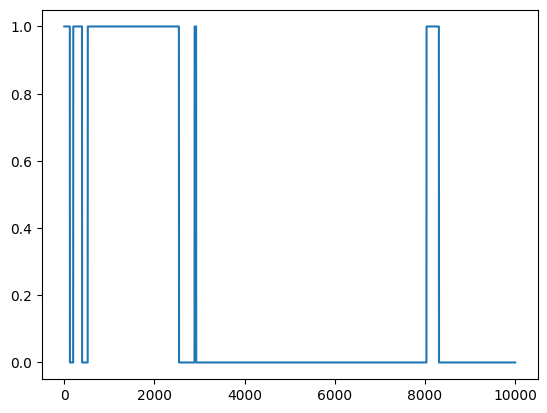

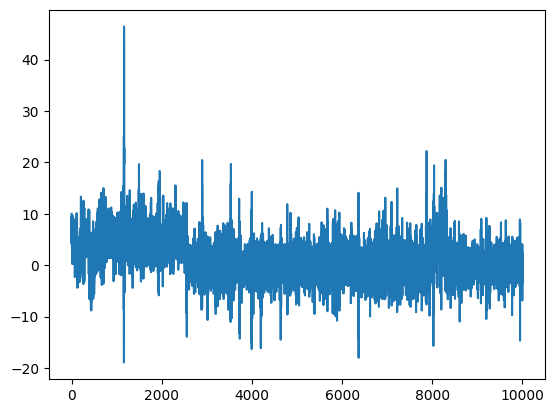

In [69]:
# генерация выборки

p_11, p_12, p_21, p_22 = 0.999, 0.001, 0.001, 0.999
t = 10000
xi_0 = [0.5, 0.5]

rng = random.Random(42)

import random 
s = [rng.choices([0, 1], weights=xi_0)[0]]
for i in range(1, t):
    if s[i - 1] == 0: s.append(rng.choices([0, 1], weights=[p_11, p_12])[0])
    else: s.append(rng.choices([0, 1], weights=[p_21, p_22])[0])

alpha = [0, 5]
beta_0 = [1, 1.001]
beta_1 = [0.3, 0.31]
gamma = [0.6, 0.61]

sigma_0sq = 10 # начнем с 10

z = norm.rvs(loc=0, scale=1, size=t, random_state=42) # вектор z_t


sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0[s[i]] + beta_1[s[i]] * epsilon[i - 1]**2 + gamma[s[i]] * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

y = []
for i in range(len(z)):
    y.append(alpha[s[i]] + epsilon[i])


plt.plot(s)
plt.show()
plt.plot(y)
plt.show()


In [70]:
# функция правдоподобия
p_11, p_12, p_21, p_22 = 0.999, 0.001, 0.001, 0.999
t = 10000
xi_0 = [0.5, 0.5]

def calc_logL_fast(theta, sigma_0sq, y, t):

    alpha = [theta[0], theta[1]]
    beta_0 = [theta[2], theta[3]]
    beta_1 = [theta[4], theta[5]]
    gamma = [theta[6], theta[7]]

    xi_tt = []
    xi_ttm1 = [[0.5, 0.5]]
    phi = []
    sigmasq = [sigma_0sq]

    phi_0 = norm.pdf(y[0], loc=alpha[0], scale=sigmasq[0]**0.5)
    phi_1 = norm.pdf(y[0], loc=alpha[1], scale=sigmasq[0]**0.5)

    phi.append([phi_0, phi_1])

    dot_product = xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1]

    xi_0 = (phi[0][0] * xi_ttm1[0][0]) / dot_product
    xi_1 = (phi[0][1] * xi_ttm1[0][1]) / dot_product

    xi_tt.append([xi_0, xi_1])

    logL = m.log(xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1])

    for i in range(1, t):
        
        xi_0 = xi_tt[i - 1][0] * p_11 + xi_tt[i - 1][1] * p_12 
        xi_1 = xi_tt[i - 1][0] * p_21 + xi_tt[i - 1][1] * p_22

        xi_ttm1.append([xi_0, xi_1])


        sigma_00sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[0])**2 + gamma[0]*sigmasq[i - 1]
        sigma_01sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[1])**2 + gamma[0]*sigmasq[i - 1]

        sigma_10sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[0])**2 + gamma[1]*sigmasq[i - 1]
        sigma_11sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[1])**2 + gamma[1]*sigmasq[i - 1]

        sigma_sq = xi_tt[i - 1][0] * (p_11 * (alpha[0]**2 + sigma_00sq) + p_12 * (alpha[1]**2 + sigma_01sq)) + xi_tt[i - 1][1] * (p_21 * (alpha[0]**2 + sigma_10sq) + p_22 * (alpha[1]**2 + sigma_11sq)) - (xi_ttm1[i][0] * alpha[0] + xi_ttm1[i][1] * alpha[1])**2

        sigmasq.append(sigma_sq)

        phi_0 = norm.pdf(y[i], loc=alpha[0], scale=sigmasq[i]**0.5)
        phi_1 = norm.pdf(y[i], loc=alpha[1], scale=sigmasq[i]**0.5)

        phi.append([phi_0, phi_1])
        
        dot_product = xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1]

        xi_0 = (phi[i][0] * xi_ttm1[i][0]) / dot_product
        xi_1 = (phi[i][1] * xi_ttm1[i][1]) / dot_product

        xi_tt.append([xi_0, xi_1])
    
        add = m.log(xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1])
        logL += add 

    return logL

In [ ]:
# истинные параметры
alpha = [0, 5]
beta_0 = [1, 1.001]
beta_1 = [0.3, 0.31]
gamma = [0.6, 0.61]

In [71]:
# поиск оценки максимального правдоподобия
from scipy.optimize import minimize

start_theta = [-0.1, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]

def optimize_function(theta):
    return -1 * calc_logL_fast(theta=theta, sigma_0sq=10, y=y, t=t)

result = minimize(optimize_function, start_theta, bounds=[(-0.1, 0.5), (4.7, 5.2), (0.8, 1.1), (0.9, 1.2), (0.25, 0.31), (0.25, 0.32), (0.57, 0.61), (0.59, 0.62)])

print(result.x)
print(calc_logL_fast(result.x, sigma_0sq=10, y=y, t=t))

[-0.01929522  5.07448586  1.1         1.19994301  0.28403508  0.26410478
  0.58911762  0.59      ]
-24444.56833501596


## Численно вычисляю гессиан функции правдоподобия

In [66]:
def numerical_hessian(func, theta_0, eps=1e-5):
    n = len(theta_0)
    hessian = np.zeros((n, n))
    theta = theta_0.copy()

    for i in range(n):
        for j in range(i, n): 
            theta_plus_i_plus_j = theta.copy()
            theta_plus_i_plus_j[i] += eps
            theta_plus_i_plus_j[j] += eps
            f_pp = func(theta_plus_i_plus_j)

            theta_plus_i_minus_j = theta.copy()
            theta_plus_i_minus_j[i] += eps
            theta_plus_i_minus_j[j] -= eps
            f_pm = func(theta_plus_i_minus_j)

            theta_minus_i_plus_j = theta.copy()
            theta_minus_i_plus_j[i] -= eps
            theta_minus_i_plus_j[j] += eps
            f_mp = func(theta_minus_i_plus_j)

            theta_minus_i_minus_j = theta.copy()
            theta_minus_i_minus_j[i] -= eps
            theta_minus_i_minus_j[j] -= eps
            f_mm = func(theta_minus_i_minus_j)

            hessian[i, j] = np.around((f_pp - f_pm - f_mp + f_mm) / (4 * eps**2), 4)
            hessian[j, i] = hessian[i, j] 

    return hessian

In [73]:
def func(theta_0):
    return calc_logL_fast(theta=theta_0, sigma_0sq=sigma_0sq, y=y, t=t)

res = numerical_hessian(func, result.x, eps=1e-5)
print(res)

[[-1.35825760e+03  2.91040000e+00  5.09320000e+00  2.38290000e+00
   6.52108000e+01  4.07908000e+01  1.48966100e+02  4.66207000e+01]
 [ 2.91040000e+00 -4.60859200e+02 -6.03900000e+00 -8.46740000e+00
  -4.43924000e+01 -5.86715000e+01 -6.58656000e+01 -1.02963900e+02]
 [ 5.09320000e+00 -6.03900000e+00 -6.34836400e+02 -1.54610000e+00
  -2.24032190e+03 -4.85670000e+00 -3.83907720e+03 -1.63527000e+01]
 [ 2.38290000e+00 -8.46740000e+00 -1.54610000e+00 -2.01544000e+02
  -1.25419000e+01 -7.97599600e+02 -1.59434000e+01 -1.27307430e+03]
 [ 6.52108000e+01 -4.43924000e+01 -2.24032190e+03 -1.25419000e+01
  -1.57295017e+04 -9.15043000e+01 -1.82156964e+04 -2.76440900e+02]
 [ 4.07908000e+01 -5.86715000e+01 -4.85670000e+00 -7.97599600e+02
  -9.15043000e+01 -6.15949830e+03 -2.21589300e+02 -6.77396200e+03]
 [ 1.48966100e+02 -6.58656000e+01 -3.83907720e+03 -1.59434000e+01
  -1.82156964e+04 -2.21589300e+02 -2.82944529e+04 -4.39176800e+02]
 [ 4.66207000e+01 -1.02963900e+02 -1.63527000e+01 -1.27307430e+03
  -

In [81]:
for i in range(8):
    for j in range(8):
        print(round(res[i][j], 2))
    print('\n')

-1358.26
2.91
5.09
2.38
65.21
40.79
148.97
46.62


2.91
-460.86
-6.04
-8.47
-44.39
-58.67
-65.87
-102.96


5.09
-6.04
-634.84
-1.55
-2240.32
-4.86
-3839.08
-16.35


2.38
-8.47
-1.55
-201.54
-12.54
-797.6
-15.94
-1273.07


65.21
-44.39
-2240.32
-12.54
-15729.5
-91.5
-18215.7
-276.44


40.79
-58.67
-4.86
-797.6
-91.5
-6159.5
-221.59
-6773.96


148.97
-65.87
-3839.08
-15.94
-18215.7
-221.59
-28294.45
-439.18


46.62
-102.96
-16.35
-1273.07
-276.44
-6773.96
-439.18
-10166.63




In [65]:
print(np.around(res,4))

[[-1.35825760e+03  2.91040000e+00  5.09320000e+00  2.38290000e+00
   6.52108000e+01  4.07908000e+01  1.48966100e+02  4.66207000e+01]
 [ 2.91040000e+00 -4.60859200e+02 -6.03900000e+00 -8.46740000e+00
  -4.43924000e+01 -5.86715000e+01 -6.58656000e+01 -1.02963900e+02]
 [ 5.09320000e+00 -6.03900000e+00 -6.34836400e+02 -1.54610000e+00
  -2.24032190e+03 -4.85670000e+00 -3.83907720e+03 -1.63527000e+01]
 [ 2.38290000e+00 -8.46740000e+00 -1.54610000e+00 -2.01544000e+02
  -1.25419000e+01 -7.97599600e+02 -1.59434000e+01 -1.27307430e+03]
 [ 6.52108000e+01 -4.43924000e+01 -2.24032190e+03 -1.25419000e+01
  -1.57295017e+04 -9.15043000e+01 -1.82156964e+04 -2.76440900e+02]
 [ 4.07908000e+01 -5.86715000e+01 -4.85670000e+00 -7.97599600e+02
  -9.15043000e+01 -6.15949830e+03 -2.21589300e+02 -6.77396200e+03]
 [ 1.48966100e+02 -6.58656000e+01 -3.83907720e+03 -1.59434000e+01
  -1.82156964e+04 -2.21589300e+02 -2.82944529e+04 -4.39176800e+02]
 [ 4.66207000e+01 -1.02963900e+02 -1.63527000e+01 -1.27307430e+03
  -

In [76]:
def is_negative_definite(A):
    eigenvalues = np.linalg.eigvalsh(A) 
    return np.all(eigenvalues < 0)

print(is_negative_definite(res))

True


## Смотрю на сходимость параметров


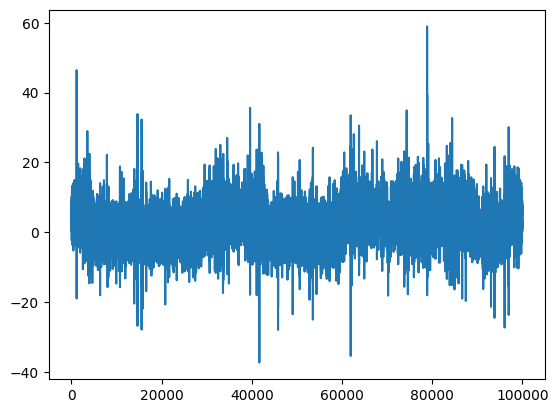

In [45]:
# генерация выборки

p_11, p_12, p_21, p_22 = 0.9999, 0.0001, 0.0001, 0.9999
t = 100000
xi_0 = [0.5, 0.5]

rng = random.Random(42)

import random 
s = [rng.choices([0, 1], weights=xi_0)[0]]
for i in range(1, t):
    if s[i - 1] == 0: s.append(rng.choices([0, 1], weights=[p_11, p_12])[0])
    else: s.append(rng.choices([0, 1], weights=[p_21, p_22])[0])

alpha = [0, 5]
beta_0 = [1, 1.001]
beta_1 = [0.3, 0.31]
gamma = [0.6, 0.61]

sigma_0sq = 10 # начнем с 10

z = norm.rvs(loc=0, scale=1, size=t, random_state=42) # вектор z_t


sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0[s[i]] + beta_1[s[i]] * epsilon[i - 1]**2 + gamma[s[i]] * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

y = []
for i in range(len(z)):
    y.append(alpha[s[i]] + epsilon[i])


plt.plot(y)
plt.show()


In [46]:
print(t)

100000


In [53]:
count_arr = [1000*i for i in range(1, 101)]
len(count_arr)

100

In [54]:
print(count_arr)

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000]


In [55]:
from tqdm import tqdm

theta_true = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]

# start_theta = [-0.3, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]

alpha_1_estimated = []

for t in tqdm(count_arr):
    start_alpha = 0.1

    def optimize_function(alpha_1):
        theta = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]
        theta[0] = alpha_1
        return -1 * calc_logL_fast(theta=theta, sigma_0sq=10, y=y[:t], t=t)

    result = minimize(optimize_function, start_alpha, bounds=[(-0.3, 0.3)])
    alpha_1_estimated.append(result.x[0])

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/_8/qj_zjpkx18bcv75rjs72zckh0000gn/T/ipykernel_54041/3214158136.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logL = m.log(xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1])
/var/folders/_8/qj_zjpkx18bcv75rjs72zckh0000gn/T/ipykernel_54041/3214158136.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  add = m.log(xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1])
100%|██████████| 100/100 [1:06:56<00:00, 40.17s/it]


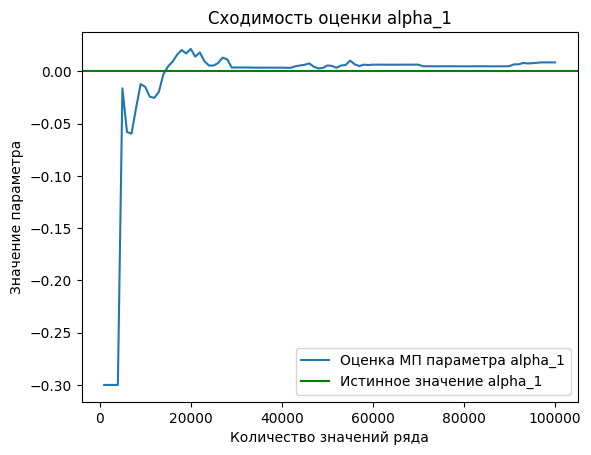

In [83]:
plt.plot(count_arr[:len(alpha_1_estimated)], alpha_1_estimated, label='Оценка МП параметра alpha_1')
plt.axhline(theta_true[0], color='g', label='Истинное значение alpha_1')
plt.xlabel('Количество значений ряда')
plt.ylabel('Значение параметра')
plt.title('Сходимость оценки alpha_1')
plt.legend(loc='best')  
plt.show()

In [57]:
from tqdm import tqdm

theta_true = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]

# start_theta = [-0.3, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]

bet_01_estimated = []

for t in tqdm(count_arr):
    start_beta_01 = 0.9

    def optimize_function(beta_01):
        theta = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]
        theta[2] = beta_01
        return -1 * calc_logL_fast(theta=theta, sigma_0sq=10, y=y[:t], t=t)

    result = minimize(optimize_function, start_beta_01, bounds=[(0.8, 1.2)])
    bet_01_estimated.append(result.x[0])

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/_8/qj_zjpkx18bcv75rjs72zckh0000gn/T/ipykernel_54041/3214158136.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  add = m.log(xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1])
100%|██████████| 100/100 [44:28<00:00, 26.68s/it]


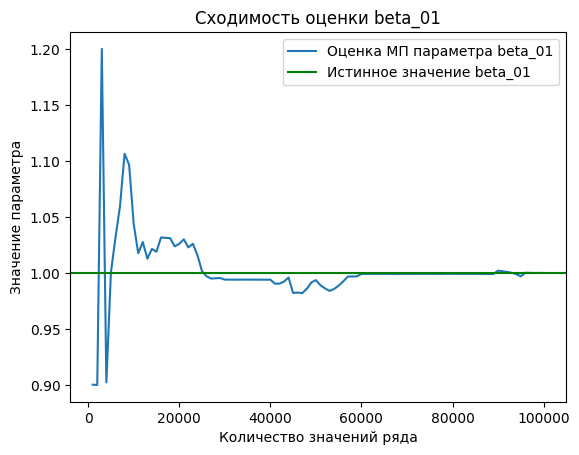

In [85]:
plt.plot(count_arr[:len(bet_01_estimated)],bet_01_estimated, label='Оценка МП параметра beta_01')
plt.axhline(theta_true[2], color='g', label='Истинное значение beta_01')
plt.xlabel('Количество значений ряда')
plt.ylabel('Значение параметра')
plt.title('Сходимость оценки beta_01')
plt.legend(loc='best')  
plt.show()

## Проверка данных на SP500

In [98]:
df = pd.read_csv('SPX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


In [123]:
snp500 = df[(df['Date'] >= '2005')][['Date', 'Close']].reset_index()
snp500['Return'] = np.log(snp500['Close'] / snp500['Close'].shift(1))
snp500.drop(0, inplace=True)
snp500.head()

,index,Date,Close,Return
1,19335,2005-01-04,1188.050049,-0.011740
2,19336,2005-01-05,1183.739990,-0.003634
3,19337,2005-01-06,1187.890015,0.003500
4,19338,2005-01-07,1186.189941,-0.001432
5,19339,2005-01-10,1190.250000,0.003417


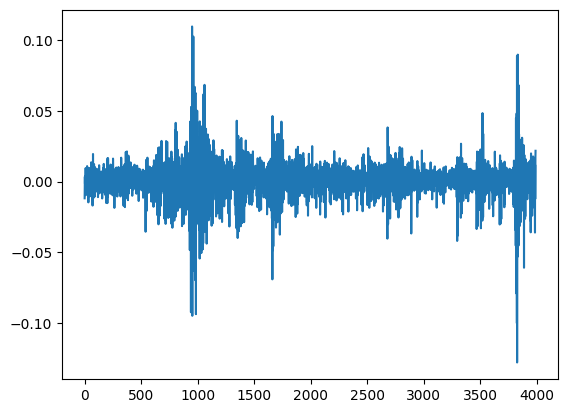

In [124]:
plt.plot(snp500['Return'])
plt.show()

In [198]:
# функция правдоподобия с оценкой параметров
t = len(snp500)
xi_0 = [0.5, 0.5] #пусть изначально мы находимся в состоянии 1 с вероятностью 1

def calc_logL_state(theta, p, sigma_0sq, y, t):

    p_11, p_22 = p[0], p[1]
    p_12 = 1 - p_11
    p_21 = 1 - p_22

    alpha = [0.001, -0.001]
    beta_0 = [theta[0], theta[1]]
    beta_1 = [theta[2], theta[3]]
    gamma = [theta[4], theta[5]]

    xi_0 = [0.5, 0.5]

    xi_tt = []
    xi_ttm1 = [xi_0]
    phi = []
    sigmasq = [sigma_0sq]

    phi_0 = norm.pdf(y[0], loc=alpha[0], scale=sigmasq[0]**0.5)
    phi_1 = norm.pdf(y[0], loc=alpha[1], scale=sigmasq[0]**0.5)

    phi.append([phi_0, phi_1])

    dot_product = xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1]

    xi_0 = (phi[0][0] * xi_ttm1[0][0]) / dot_product
    xi_1 = (phi[0][1] * xi_ttm1[0][1]) / dot_product

    xi_tt.append([xi_0, xi_1])

    logL = m.log(xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1])

    for i in range(1, t):
        
        xi_0 = xi_tt[i - 1][0] * p_11 + xi_tt[i - 1][1] * p_12 
        xi_1 = xi_tt[i - 1][0] * p_21 + xi_tt[i - 1][1] * p_22

        xi_ttm1.append([xi_0, xi_1])


        sigma_00sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[0])**2 + gamma[0]*sigmasq[i - 1]
        sigma_01sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[1])**2 + gamma[0]*sigmasq[i - 1]

        sigma_10sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[0])**2 + gamma[1]*sigmasq[i - 1]
        sigma_11sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[1])**2 + gamma[1]*sigmasq[i - 1]

        sigma_sq = xi_tt[i - 1][0] * (p_11 * (alpha[0]**2 + sigma_00sq) + p_12 * (alpha[1]**2 + sigma_01sq)) + xi_tt[i - 1][1] * (p_21 * (alpha[0]**2 + sigma_10sq) + p_22 * (alpha[1]**2 + sigma_11sq)) - (xi_ttm1[i][0] * alpha[0] + xi_ttm1[i][1] * alpha[1])**2

        sigmasq.append(sigma_sq)

        phi_0 = norm.pdf(y[i], loc=alpha[0], scale=sigmasq[i]**0.5)
        phi_1 = norm.pdf(y[i], loc=alpha[1], scale=sigmasq[i]**0.5)

        phi.append([phi_0, phi_1])
        
        dot_product = xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1]

        xi_0 = (phi[i][0] * xi_ttm1[i][0]) / dot_product
        xi_1 = (phi[i][1] * xi_ttm1[i][1]) / dot_product

        xi_tt.append([xi_0, xi_1])
    
        add = m.log(xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1])
        logL += add 

    return logL

In [199]:
theta_start = [0.1, 0.13, 0.03, 0.07, 0.06, 0.062]

p_start = [0.001, 0.999]

calc_logL_state(theta_start, p=p_start, y=np.array(snp500['Return']), sigma_0sq=10, t=len(snp500))

516.4742952167124

In [233]:
theta_start = [0, 0, 0.056, 0.073, 0.915, 0.509]

p_start = [0.999, 0.999]

arg_start = theta_start + p_start


y = np.array(snp500['Return'])
t = len(y)

def optimize_function(arg):
    theta = arg[:6]
    p = arg[6:8]
    return -1 * calc_logL_state(theta=theta, p=p, sigma_0sq=0.01, y=y, t=t)

bounds = [(0, 0.001), (0, 0.001), (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1), (0.1, 0.999), (0.1, 0.999)]

result = minimize(optimize_function, arg_start, bounds=bounds)
print(result.x)

[0.00000000e+00 8.22557747e-06 2.09877301e-01 2.24106264e-01
 9.28855197e-01 5.89035574e-01 8.52457555e-01 9.98999356e-01]


In [206]:
calc_logL_state(theta=[0, 0, 0.056, 0.073, 0.915, 0.509], p=[0.979, 0.979], sigma_0sq=0.001, y=y, t=t)

8926.07190516488

In [197]:
calc_logL_state(theta=[0.001, 0.001, 0.001, 0.001, 0.001, 0.001], p=[0.999, 0.9], sigma_0sq=0.001, y=y, t=t)

9795.073611049516

In [207]:
calc_logL_state(theta=result.x[:6], p=result.x[6:8], sigma_0sq=0.001, y=y, t=t)

12967.905468758781